In [113]:
import numpy as np
import pandas as pd

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(y, y_hat):
    y_hat = np.clip(y_hat, 1e-15, 1 - 1e-15)
    return -np.mean(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))

def compute_gradient(w, X, b, y):
    m = len(y)
    y_hat = sigmoid(np.dot(X, w) + b)
    error = y_hat - y
    gradient_w = np.dot(X.T, error) / m
    gradient_b = np.sum(error) / m
    return gradient_w, gradient_b

def predict_proba(w, X, b):
    return sigmoid(np.dot(X, w) + b)

def train_lrgd(X, y, alpha, num_rounds):
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.DataFrame):
        y = y.values.flatten()

    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

    n = X.shape[1]
    w = np.zeros(n)
    b = 0.0
    loss_history = []

    for _ in range(num_rounds):
        gradient_w, gradient_b = compute_gradient(w, X, b, y)
        w -= alpha * gradient_w
        b -= alpha * gradient_b
        y_hat = predict_proba(w, X, b)
        loss_history.append(compute_loss(y, y_hat))

    return w, b, loss_history

In [143]:
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("../data/features.csv")
df = df.loc[:100]
X = df.drop("Exited", axis=1)
y = df["Exited"]

alphas = [0.01, 0.1, 1, 10, 100]
loss_log = {}
for alpha in alphas:
    w, b, loss = train_lrgd(X, y, alpha, 1000)
    loss_log[alpha] = loss

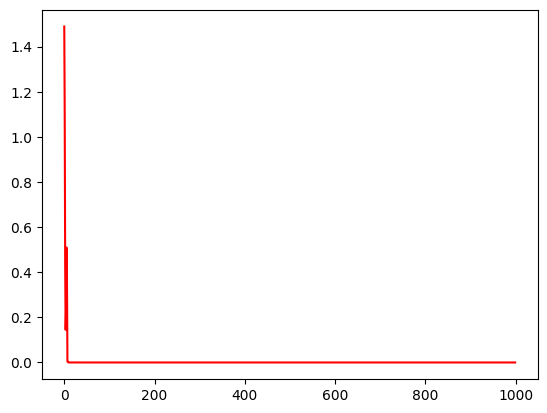

In [144]:
# fig, axs = plt.subplots(1, 5)

# for ax in axs:
# plt.plot(loss_log[0.1], "b")
# plt.plot(loss_log[1], "y")
plt.plot(loss_log[100], "r")

In [120]:
y_hat = predict_proba(w, X, b)
y_hat

/tmp/ipykernel_25032/3830955922.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [89]:
y

0      1
1      0
2      1
3      0
4      0
      ..
96     0
97     0
98     0
99     0
100    0
Name: Exited, Length: 101, dtype: int64